In [1]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from helpers import *
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.pipeline import Pipeline
# Algorithms
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,ElasticNetCV,ElasticNet
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import lightgbm as lgb

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
train = pd.read_pickle('../data/feature_engineering/sub_train_bin.pkl')
test = pd.read_pickle('../data/feature_engineering/sub_test_bin.pkl')

In [5]:
train_X = train.drop(['sample_name','phenotype_status'],axis=1).values
test_X = test.drop(['sample_name','phenotype_status'],axis=1).values
# train_X = train[kept_TCRs].values
# test_X = test[kept_TCRs].values
train_y = train['phenotype_status'].values
test_y = test['phenotype_status'].values

In [6]:
train_X.shape

(641, 165)

In [5]:
def cal_p_value1(present_c0,present_c1,class_counts,alternative='greater'):
    '''
    present_c0: the number of negative samples where the TCR present
    present_c1: the number of positive samples where the TCR present
    class_counts: the class distribution: [class_negative(0),class_positive(1)]
    alternative: Choose the type of test: greater, less, two_sided

    contingency table: [[present_c1, absent_c1], [present_c0, absent_c0]]
    '''

    absent_c0 = class_counts[0]-present_c0 # the number of negative samples where the TCR absent 
    absent_c1 = class_counts[1]-present_c1 # the number of positive samples where the TCR absent

    # Conducting fisher exact test 
    _, pvalue = fisher_exact([[present_c1, absent_c1], [present_c0, absent_c0]],alternative=alternative)
    return pvalue

Optimal number of features : 160
AUROC: 0.8871838590508667 Accuracy:  0.8
Best_score: 0.9756016889514427


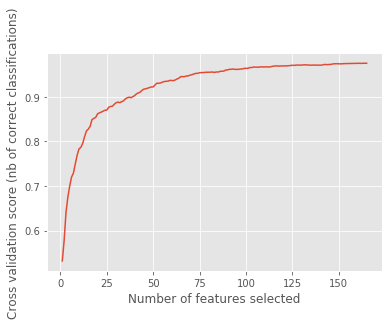

In [17]:
# Define a classifier
lr = LogisticRegression(penalty='l2',C=0.2)
# rf = RandomForestClassifier(n_estimators=100)
# lgbm = lgb.LGBMClassifier()
rfecv = RFECV(lr,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(train_X,train['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test['phenotype_status'],rfecv.predict_proba(test_X)[:,1]),'Accuracy: ',accuracy_score(test['phenotype_status'],
        rfecv.predict(test_X)))
print('Best_score:',max(rfecv.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

Optimal number of features : 159
AUROC: 0.9147485080988917 Accuracy:  0.875
Best_score: 0.9698232856360933


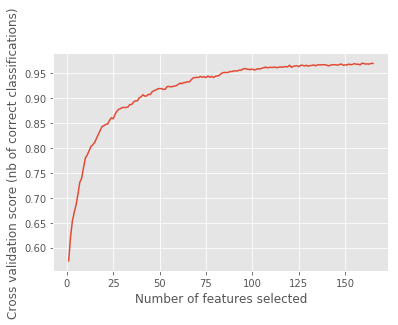

In [80]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

rfecv = RFECV(rf,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(train_X,train['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test['phenotype_status'],rfecv.predict_proba(test_X)[:,1]),'Accuracy: ',accuracy_score(test['phenotype_status'],
        rfecv.predict(test_X)))
print('Best_score:',max(rfecv.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5]
cv_auroc = []
for t in thresholds:
    
    auroc = []
    lr = LogisticRegression()
    kf = StratifiedKFold(10)
    TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns.values
    for train_index,test_index in kf.split(train_X,train_y): # for each cv round
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = y[train_index], y[test_index]

        X_train, X_test = train_X.iloc[train_index].values, train_X.iloc[test_index].values
        y_train, y_test = train_y[train_index], train_y[test_index]

        # We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
        
        # Set a minimum threshold of 0.25
        sfm = SelectFromModel(lr, threshold=t)
        sfm.fit(X_train,y_train)
        train_X_new = sfm.transform(X_train,y_train)
        test_X_new = sfm.transform(X_test)
        
        auroc.append(roc_auc_score(y_test,lr.predict_proba(X_test)[:,1]))
    print('threshold:',t,'')
    cv_auroc.append(np.mean(auroc))

In [13]:
rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()

In [65]:
pipeline = Pipeline([
    ('fs', SelectFromModel(rf)),
    ('estimator', lr),
])
params = {
    'fs__threshold': ['0.2*mean','0.25*mean','0.3*mean','0.4*mean','median'],
    'estimator__C': [0.5,1,5,10],
#     'clf__max_features': ['auto', 'sqrt', 'log2'],
 }
cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=params)
cv_pipeline.fit(X=train_X, y=train_y)
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['estimator']

In [66]:
final_classifier

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
fs = cv_pipeline.best_estimator_.named_steps['fs']
fs.threshold

'0.2*mean'

In [68]:
TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns.values
feature_names = np.array(TCRs)
selected_features = feature_names[fs.get_support()]

In [69]:
len(selected_features)

159

In [8]:
train_TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns

In [75]:
train_TCRs.columns = pd.MultiIndex.from_tuples(train_TCRs.columns, names=['V_family','V_gene','V_allele','CDR3','J_family','J_gene','J_allele'])

In [17]:
d = dict()
for i in train_TCRs:
    if i[0] in d:
        d[i[0]] += 1
    else:
        d[i[0]] = 1

In [18]:
len(list(d.keys()))

21

In [19]:
d

{'TCRBV02': 7,
 'TCRBV03': 3,
 'TCRBV04': 4,
 'TCRBV05': 27,
 'TCRBV06': 23,
 'TCRBV07': 20,
 'TCRBV09': 7,
 'TCRBV10': 4,
 'TCRBV11': 5,
 'TCRBV12': 8,
 'TCRBV14': 7,
 'TCRBV15': 5,
 'TCRBV18': 4,
 'TCRBV19': 9,
 'TCRBV20': 4,
 'TCRBV24': 5,
 'TCRBV25': 4,
 'TCRBV27': 2,
 'TCRBV28': 10,
 'TCRBV29': 5,
 'TCRBV30': 2}

In [23]:
t = pd.DataFrame(d,index=[0])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b67caf6c518>,
      dtype=object)

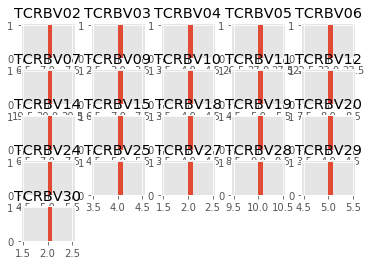

In [24]:
t.hist()

In [79]:
train_TCRs.groupby(level='V_family')

ValueError: level name V_family is not the name of the index